# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [7]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d



def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def thresholdImage(I,s):
    """ Array*int -> Array """
    I2 = I.copy()
    I2[I2 < s] = 0
    I2[I2 != 0] = 255
    return I2

def SobelDetector(I, s):
    """ Array*double -> Array """
    Ix = convolve2d(I, Sx, mode='same')
    Iy = convolve2d(I, Sy, mode= 'same')
    Ig = np.sqrt(Ix**2 + Iy**2)
    Ig = thresholdImage(Ig, s)

    return Ig, Ix, Iy

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [8]:
Sx = np.array([[1 , 0,  -1], [2, 0, -2], [1, 0, -1] ])
Sy = np.array([[1 , 2,  1], [0, 0, 0], [-1, -2, -1] ])

In [12]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ig,Ix,Iy = SobelDetector(image,scale) 
    
    Ix_2 = Ix**2
    Iy_2 = Iy**2
    Ixy = Ix * Iy
    
    sigma = (scale-1)/6
    w = gaussianKernel(sigma)
    
    w_Ix_2 = convolve2d(Ix_2, w, mode = "same") #A
    w_Iy_2 = convolve2d(Iy_2, w, mode = "same") #B
    w_Ixy_2 = convolve2d(Ixy, w, mode = "same") #C

    
    det = w_Ix_2 * w_Iy_2 - w_Ixy_2**2 # AB - C^2
    trace = w_Ix_2 + w_Iy_2 # A+B

    
    R = det - kappa * (trace**2)
    
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

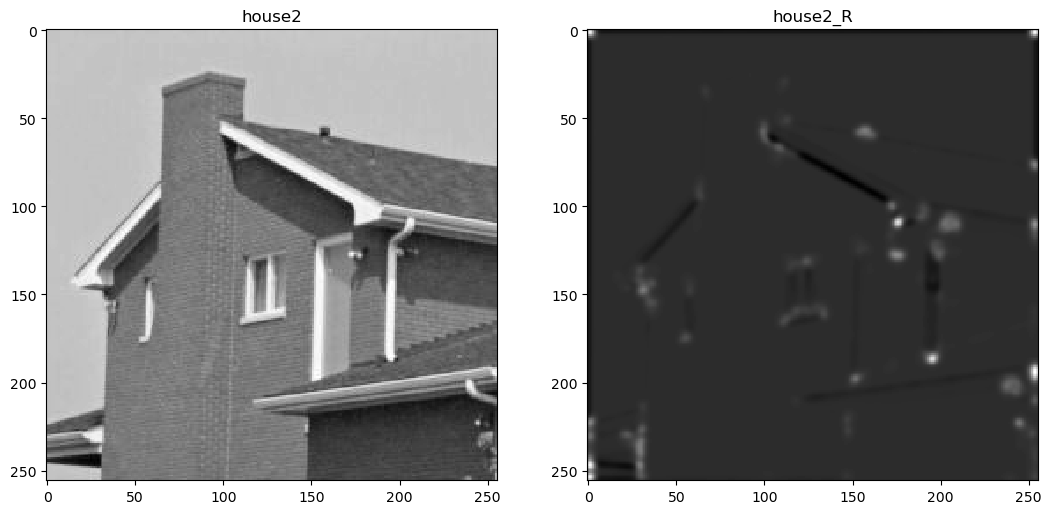

In [13]:
house2 = np.array(Image.open('img/house2.png'))
house2_R = computeR(house2,15,0.04)


niceDisplay14([house2,house2_R],['house2','house2_R'])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Your answer...

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

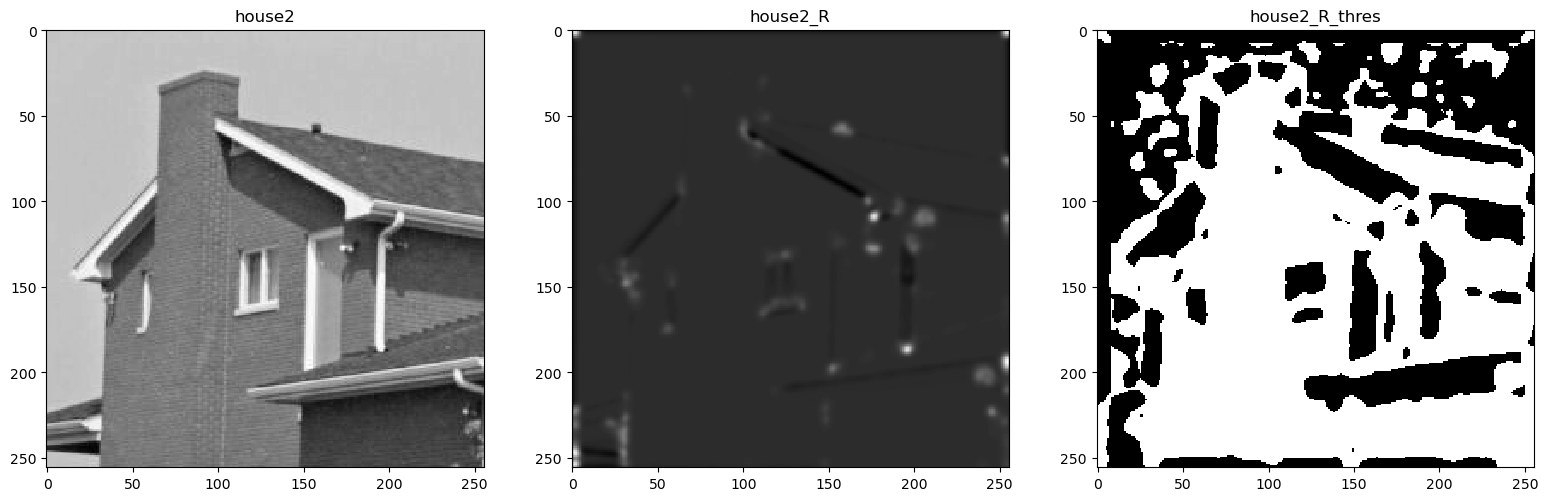

In [18]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    R2 = R.copy()
    R2[R2 < thres] = 0
    R2[R2 != 0] = 1
    return R2

house2_R_thres = thresholdR(house2_R,150)
#print(np.max(house2_R_thres))
niceDisplay14([house2,house2_R,house2_R_thres],['house2','house2_R','house2_R_thres'])

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [24]:
def rnms(image_harris, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    R_locmax = np.zeros(image_harris.shape)

    # Iterate over the image and find zero crossings
    for i in range(1, image_harris.shape[0] - 1):
        for j in range(1, image_harris.shape[1] - 1):
            
            # Extract the 3x3 neighborhood
            neighborhood  = image_harris[i-1:i+2, j-1:j+2]
            locmax = np.max(neighborhood)
            if Rbin[i,j] == 1 and image_harris[i,j] == locmax:
                R_locmax = 1
    
    return R_locmax

AttributeError: 'int' object has no attribute 'shape'

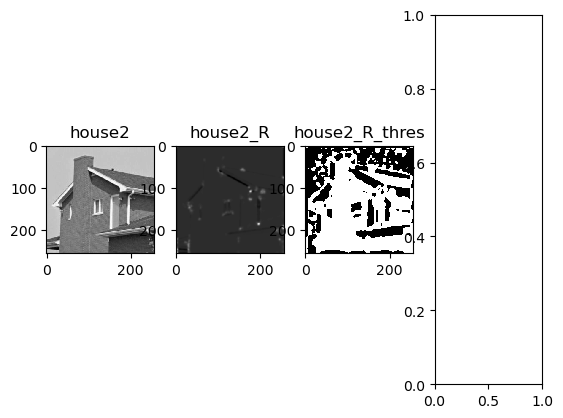

In [25]:
house2_rnms = rnms(house2_R,house2_R_thres)
niceDisplay14([house2,house2_R,house2_R_thres,house2_rnms],['house2','house2_R','house2_R_thres',''])

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [ ]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer